In [1]:
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
#plt.rc('font',family='Times New Roman') 

from astropy import units as u
from astropy.coordinates import SkyCoord
import csv
import pandas as pd
%matplotlib notebook
import math
from matplotlib.pyplot import MultipleLocator
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from astropy.stats import LombScargle
from uncertainties import ufloat
import speclite.filters

import wise_tools as wtl


from matplotlib import rcParams

config = {
            "font.family": 'serif',
            "font.size": 15,
            "mathtext.fontset": 'stix',
            "font.serif": ['Times New Roman'],
         }
rcParams.update(config)




def LSP(t,F,err):
    
    '''
    find the period in the light curve by Lomb-Scargle Periodogram(LSP)

    '''
    t_span = t[-1]-t[0]  #the time span of the light curve
    fmin = 1/t_span      #the minimum sampling frequency 

    p = np.mean(np.diff(t))

    fmax = 1/(p*2)
    
    N = round(10*t_span*fmax)   #the total number of required periodogram evaluation

    frequency = np.linspace(fmin,fmax,N)  #the sampling frequency


    ls = LombScargle(t, F, err)    #compute the Lomb-Scargle Periodogram
    power = ls.power(frequency)    #the Lomb-Scargle power at the given frequencies.


    best_frequency = frequency[np.argmax(power)]  #find the frequency of max power

    
    
    return best_frequency





#Sinusoidal fitting of the light curve
import lmfit
from lmfit import Minimizer, Parameters, report_fit

pfit = Parameters()

pfit.add(name='a', value=10)
pfit.add(name='b', value=0)
pfit.add(name='c', value=0)

def residual(pars, x, data, err):
    #sinusoidal function: y = a*sin(2*pi*f+b)+c
    model = pars['a']*np.sin(2*np.pi*best_frequency*x+pars['b'])+pars['c']
    
    return (model - data)/err

def func(pars, x):
    func =  pars['a']*np.sin(2*np.pi*best_frequency*x+pars['b'])+pars['c']
    return func


def sinfit(t, F, err):

    t_fit = np.linspace(t[0], t[-1], 5000)    #Time of the fitted sine function
    mini = Minimizer(residual, pfit, fcn_args=(t, F,err))  
    out = mini.leastsq()    #Best Fit Parameters
    best_fit = func(out.params, t_fit)  #Best-fit sinusoidal function curve
    return t_fit, best_fit, out



In [2]:
#Load IR band lighe curves


#Load the ALL WISE data
NEO_WISE = pd.read_csv('J2134-0153_NEOWISE.csv')
t_NEOWISE = NEO_WISE['mjd']
W1_NEOWISE = NEO_WISE['w1mpro']
W1err_NEOWISE = NEO_WISE['w1sigmpro']
W2_NEOWISE = NEO_WISE['w2mpro']
W2err_NEOWISE = NEO_WISE['w2sigmpro']


#remove the bad data
sel_NEOWISE = np.where((NEO_WISE['qi_fact']>=1) & (NEO_WISE['moon_masked']<=0)&(NEO_WISE['saa_sep']>=5), True, False)
t_NEOWISE = t_NEOWISE[sel_NEOWISE]
W1_NEOWISE = W1_NEOWISE[sel_NEOWISE]
W1err_NEOWISE = W1err_NEOWISE[sel_NEOWISE]
W2_NEOWISE = W2_NEOWISE[sel_NEOWISE]
W2err_NEOWISE = W2err_NEOWISE[sel_NEOWISE]





#Load the NEO WISE data
WISE = pd.read_csv('J2134-0153_WISE.csv')
t_WISE = WISE['mjd']
W1_WISE = WISE['w1mpro_ep']
W1err_WISE = WISE['w1sigmpro_ep']
W2_WISE = WISE['w2mpro_ep']
W2err_WISE = WISE['w2sigmpro_ep']


#remove the bad data
sel_WISE = np.where((WISE['qi_fact']>=1) & (WISE['moon_masked']<=0)&(WISE['saa_sep']>=5), True, False)
t_WISE = t_WISE[sel_WISE]
W1_WISE = W1_WISE[sel_WISE]
W1err_WISE = W1err_WISE[sel_WISE]
W2_WISE = W2_WISE[sel_WISE]
W2err_WISE = W2err_WISE[sel_WISE]



#Merge these light curves
t_wise_all = np.append(t_NEOWISE,t_WISE)
W1_all = np.append(W1_NEOWISE,W1_WISE)
W1err_all = np.append(W1err_NEOWISE,W1err_WISE)
W2_all = np.append(W2_NEOWISE,W2_WISE)
W2err_all = np.append(W2err_NEOWISE,W2err_WISE)


#Make sure the time for light curves are increased
seq_WISE_all = np.argsort(t_wise_all)
t_WISE_seq = np.array(t_wise_all[seq_WISE_all])
W1_mag_seq = np.array(W1_all[seq_WISE_all])
W1_mag_err_seq = np.array(W1err_all[seq_WISE_all])
W2_mag_seq = np.array(W2_all[seq_WISE_all])
W2_mag_err_seq = np.array(W2err_all[seq_WISE_all])



#Binned these light curves by 180 days
rebin_W1 = wtl.rebin(t=t_WISE_seq, x=W1_mag_seq,xe =W1_mag_err_seq, tduration=180)
rebin_W2 = wtl.rebin(t=t_WISE_seq, x=W2_mag_seq,xe =W2_mag_err_seq, tduration=180)

t_IR = rebin_W1[0]
W1 = rebin_W1[1]
W1err = rebin_W1[2]
W2 = rebin_W2[1]
W2err = rebin_W2[2]


In [3]:
#find the frequency of max power by LSP

best_frequency_W1 = LSP(t_IR,W1,W1err)  #The best frequency obtained from LSP analysis
best_frequency = best_frequency_W1

#Sinusoidal fitting of the W1 band light curve
best_fit_W1 = sinfit(t_IR,W1,W1err)

<IPython.core.display.Javascript object>


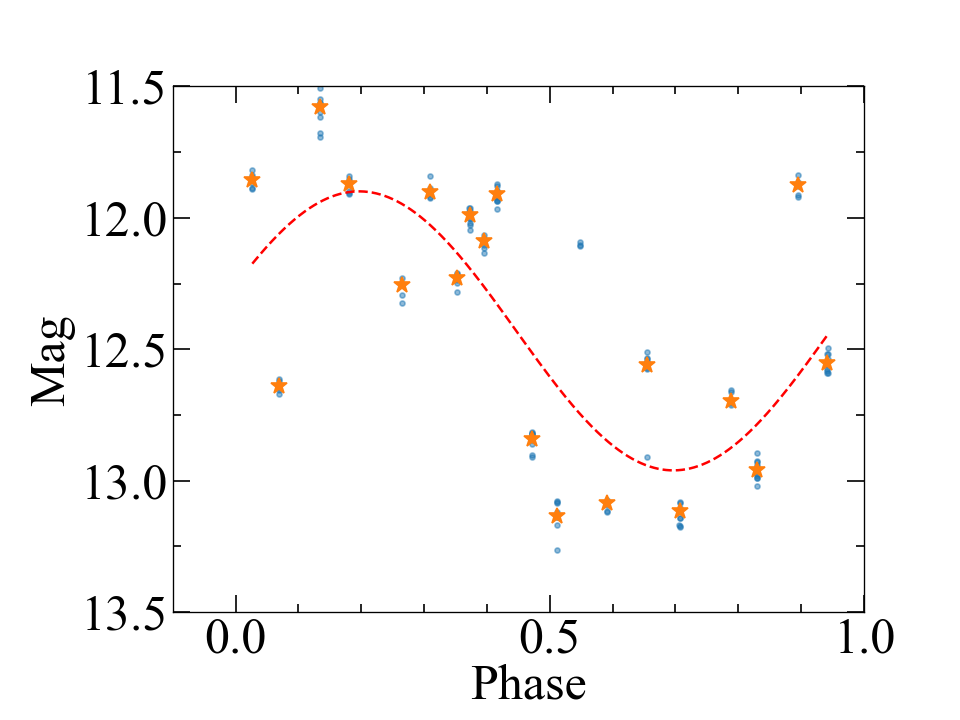

In [4]:
#Phase-folded W1-band light curve


T_W1 = 1/best_frequency_W1     #The best period obtained from LSP analysis
phase_W1 = ((t_WISE_seq - 1300 )%T_W1)/T_W1  #Folding the time of the light curve according to the best period

#Sinusoidal fitting of the phase-folded W1-band light curve
best_frequency = 1    #The best period is 1
rebin_phase_W1 = wtl.rebin(t=phase_W1, x=W1_mag_seq,xe =W1_mag_err_seq, tduration=0.01)  #Binned the folded light curve

fit_W1_fold = sinfit(rebin_phase_W1[0],rebin_phase_W1[1],rebin_phase_W1[2])  #Sinusoidal fitting of the folded W1 band light curve



# make phase plot
fig = plt.figure(figsize=(8,6))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
#plt.tick_params(bottom=True, top=True, left=True, right=True)

plt.subplots_adjust(left=0.18, bottom=0.15)
#plt.gca().tick_params(axis='both',labelsize=30)

plt.xticks(fontsize=30,color='#000000')
plt.yticks(fontsize=30,color='#000000')

plt.plot(phase_W1,W1_mag_seq,'.',alpha = 0.5)


plt.plot(rebin_phase_W1[0], rebin_phase_W1[1],'*',ms = 10)


plt.plot(fit_W1_fold[0],fit_W1_fold[1],'--', c = 'r')



fig.text(0.55, 0.03, 'Phase', ha='center', fontsize=30)
fig.text(0.03, 0.5, 'Mag', va='center', rotation='vertical', fontsize=30)



plt.tick_params(top='on', right='on', which='major',length=10, width = 1) 
plt.tick_params(top='on', right='on', which='minor',length=5, width = 1)

plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.xlim(-0.1,1)
plt.ylim(13.5,11.5)
#plt.savefig('fig3-2.pdf',dpi=300,bbox_inches='tight')

In [5]:
#find the frequency of max power by LSP
best_frequency_W1 = LSP(t_IR,W1,W1err)  #The best frequency obtained from LSP analysis



#Sinusoidal fitting of the W1 band light curve
best_frequency = best_frequency_W1
best_fit_W1_fold = sinfit(phase_W1,W1_mag_seq,W1_mag_err_seq)



In [6]:
#find the frequency of max power by LSP


best_frequency_W2 = LSP(t_IR,W2,W2err)   #The best frequency obtained from LSP analysis


#Sinusoidal fitting of the W2 band light curve
best_frequency = best_frequency_W2
best_fit_W2 = sinfit(t_IR,W2,W2err)


<IPython.core.display.Javascript object>


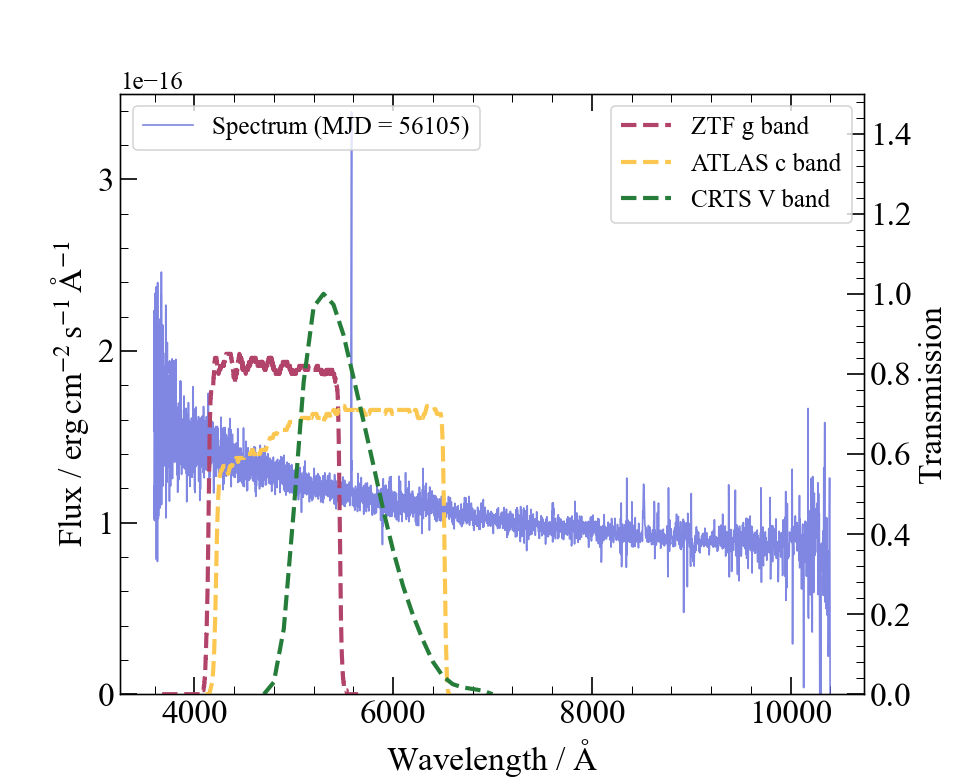

(0.0, 1.5)

In [7]:
#Load spectrum



spectrum = pf.open('spec-4384-56105-0988_SDSS.fits')   
spectrum_wavelength = (10**spectrum[1].data['loglam'])* u.Angstrom   #Wavelength of the spectrum
spectrum_flux = spectrum[1].data['flux']* u.erg / (u.cm**2 * u.s * u.Angstrom)/1e17   #Flux of the spectrum


#Convolve the SDSS spectrum with the CRTS V band filter response curve to obtain the corresponding magnitudes
fangs_CRTS_V = speclite.filters.load_filter('bessell-V')    #Load the CRTS V band filter response curve 
flux_CRTS_V, wlen_CRTS_V = fangs_CRTS_V.pad_spectrum(spectrum_flux, spectrum_wavelength)
crts_V_mag = fangs_CRTS_V.get_ab_magnitude(flux_CRTS_V, wlen_CRTS_V)  #The CRTS V band magnitude after convolution



#Convolve the SDSS spectrum with the ZTF g band filter response curve to obtain the corresponding magnitudes
ztf_g_wave,ztf_g_resp=np.loadtxt("Palomar_ZTF.g.dat",unpack=True,usecols=[0,1])   #Load the ZTF g band filter response curve 
ztf_g_waves=np.round(ztf_g_wave,2).tolist()* u.Angstrom
ztf_g_resps=np.round(ztf_g_resp,2).tolist()
ztf_g = speclite.filters.FilterResponse(wavelength = ztf_g_waves,response = ztf_g_resps, meta=dict(group_name='ztf', band_name='g'))
fangs_ztf_g = speclite.filters.load_filter('ztf-g')
flux_ztf_g, wlen_ztf_g = fangs_ztf_g.pad_spectrum(spectrum_flux, spectrum_wavelength)
ztf_g_mag = fangs_ztf_g.get_ab_magnitude(flux_ztf_g, wlen_ztf_g)   #The ZTF g band magnitude after convolution
delta_ztf_crts = ztf_g_mag - crts_V_mag  #Magnitude difference



#convolve the SDSS spectrum with the ATLAS c band filter response curve to obtain the corresponding magnitudes
c_wave,c_resp=np.loadtxt("Misc_Atlas.cyan.dat",unpack=True,usecols=[0,1])   #Load the ATLAS c band filter response curve 
c_waves=np.round(c_wave,2).tolist()* u.Angstrom
c_resps=np.round(c_resp,2).tolist()

c = speclite.filters.FilterResponse(wavelength = c_waves,response = c_resps, meta=dict(group_name='atlas', band_name='c'))
fangs_c = speclite.filters.load_filter('atlas-c')

flux_c, wavelength_c = fangs_c.pad_spectrum(spectrum_flux, spectrum_wavelength)
atlas_c_mag = fangs_c.get_ab_magnitude(flux_c, wavelength_c )   #The ATLAS c band magnitude after convolution
delta_atlas_crts = atlas_c_mag - crts_V_mag   #Magnitude difference






#make spectrum and response light curves plot
CRT = pd.read_csv("bess-v.csv")
CRTS_wave = np.array(CRT["wave"])
CRTS_resp = np.array(CRT["resp"])

fig = plt.figure(figsize= (8,6.5))
ax1 = fig.add_subplot(111)
ax1.plot(spectrum_wavelength,spectrum_flux,c = '#5F69DC',linewidth=1,alpha = 0.8)
ax1.legend(['Spectrum (MJD = 56105)'],loc = 'upper left')
plt.xlabel('Wavelength / $\mathrm{{\AA}}$', fontsize = 20)
plt.ylabel('Flux / $\mathrm{erg}\,\mathrm{cm^{-2}}\,\mathrm{s^{-1}}\,\mathrm{{\AA}^{-1}}$',fontsize = 20)
plt.gca().yaxis.set_major_locator(MultipleLocator(10e-17))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().tick_params(axis='both',labelsize=20)
plt.ylim(0,35e-17)
ax1.tick_params(top='on', right='on', which='major',length=10, width = 1) 
ax1.tick_params(top='on', right='on', which='minor',length=5)
ax1.tick_params(top='on', right='on', which='both') 
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

ax2 = ax1.twinx()
ax2.plot(ztf_g_waves, ztf_g_resps,'--', linewidth=2.5, c = '#B2446B',alpha = 1)
ax2.plot(c_waves,c_resps,'--',linewidth=2.5, c = '#FBC750')
ax2.plot(CRTS_wave, CRTS_resp,'--', linewidth=2.5, c = '#267D3A',alpha = 1)
ax2.legend(['ZTF g band','ATLAS c band','CRTS V band'],loc = 'upper right')
plt.ylabel('Transmission',fontsize = 20)
ax2.tick_params(top='on', right='on', which='major',length=10, width = 1) 
ax2.tick_params(top='on', right='on', which='minor',length=5)
ax2.tick_params(top='on', right='on', which='both') 
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().tick_params(axis='both',labelsize=20)
plt.ylim(0,1.5)
#plt.savefig('figB2.pdf', dpi=300)


In [8]:
#load optical band light curves

import matplotlib
matplotlib.interactive('True')
import numpy as np
import matplotlib.pyplot as plt


ztf_file = np.genfromtxt('PKSJ2134-ZTF.csv', delimiter=',', skip_header=1,\
    dtype=[('line', 'S8'), ('oid', '<f8'), ('expid', '<f8'), ('hjd', '<f8'),\
        ('mjd', '<f8'), ('mag', '<f8'), ('magerr', '<f8'),\
            ('catflags', '<f8'), ('filtercode', '<U8'),\
                ('ra', '<f8'), ('dec', '<f8'), ('chi', '<f8'),\
                    ('sharp', '<f8'), ('filefracday', '<f8'),\
                        ('field', 'int'), ('ccdid', '<U8'),\
                            ('qid', '<U8'), ('limitmag', '<f8'),\
                                ('magzp', '<f8'), ('magzprms', '<f8'),\
                                    ('clrcoeff', '<f8'),\
                                        ('clrcounc', '<f8'),\
                                            ('exptime', '<f8'),\
                                                ('airmass', '<f8'),\
                                                    ('programid', '<f8')])

crts_file = np.genfromtxt('PKSJ2134-CRTS.csv', delimiter=',', names=True, dtype=None)

atlas_file = np.genfromtxt('PKSJ2134-ATLAS.txt', names=True, dtype=None)

# merge these light curves
sel_ztf = np.where((ztf_file['filtercode']=='zg')&(ztf_file['catflags']==0.), True, False)
sel_crts = np.where((crts_file['Blend']==0.)&(crts_file['Mag']>0.), True, False)
sel_atlas = np.where((atlas_file['F']==b'c')&(atlas_file['m']>0.), True, False)

mjd_ztf = ztf_file['mjd'][sel_ztf]
mag_ztf = ztf_file['mag'][sel_ztf] - delta_ztf_crts # convert to V
magerr_ztf = ztf_file['magerr'][sel_ztf]

mjd_crts = crts_file['MJD'][sel_crts]
mag_crts = crts_file['Mag'][sel_crts]
magerr_crts = crts_file['Magerr'][sel_crts]

mjd_atlas = atlas_file['MJD'][sel_atlas]
mag_atlas = atlas_file['m'][sel_atlas] - delta_atlas_crts # convert to V
magerr_atlas = atlas_file['dm'][sel_atlas]


#Merge these light curves
mjd_all = np.append(mjd_crts, mjd_ztf)
mjd_all = np.append(mjd_all, mjd_atlas)

mag_all = np.append(mag_crts, mag_ztf)
mag_all = np.append(mag_all, mag_atlas)

magerr_all = np.append(magerr_crts, magerr_ztf)
magerr_all = np.append(magerr_all, magerr_atlas)

sel_sort = np.argsort(mjd_all)
mjd_all = mjd_all[sel_sort]
mag_all = mag_all[sel_sort]
magerr_all = magerr_all[sel_sort]

# save data
lc_all = np.zeros((len(mag_all), 3))
lc_all[:, 0] = mjd_all
lc_all[:, 1] = mag_all
lc_all[:, 2] = magerr_all

np.savetxt('PKS_J2134-0153_synthetic_V.csv', lc_all, delimiter=',', fmt=['%.3f', '%.2f', '%.2f'],header='mjd, mag, magerr')

#Binned the light curve by 180 days
rebin_V = wtl.rebin(t=mjd_all, x=mag_all,xe =magerr_all, tduration=180)


/home/rgw/anaconda3/envs/J2134-0153/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [9]:
#Find the frequency of max power by LSP


best_frequency_V = LSP(mjd_all,mag_all,magerr_all)   #The best frequency obtained from LSP analysis


#Sinusoidal fitting of the binned synthetic V band light curve
best_frequency = best_frequency_V
best_fit_V = sinfit(rebin_V[0],rebin_V[1],rebin_V[2])


<IPython.core.display.Javascript object>


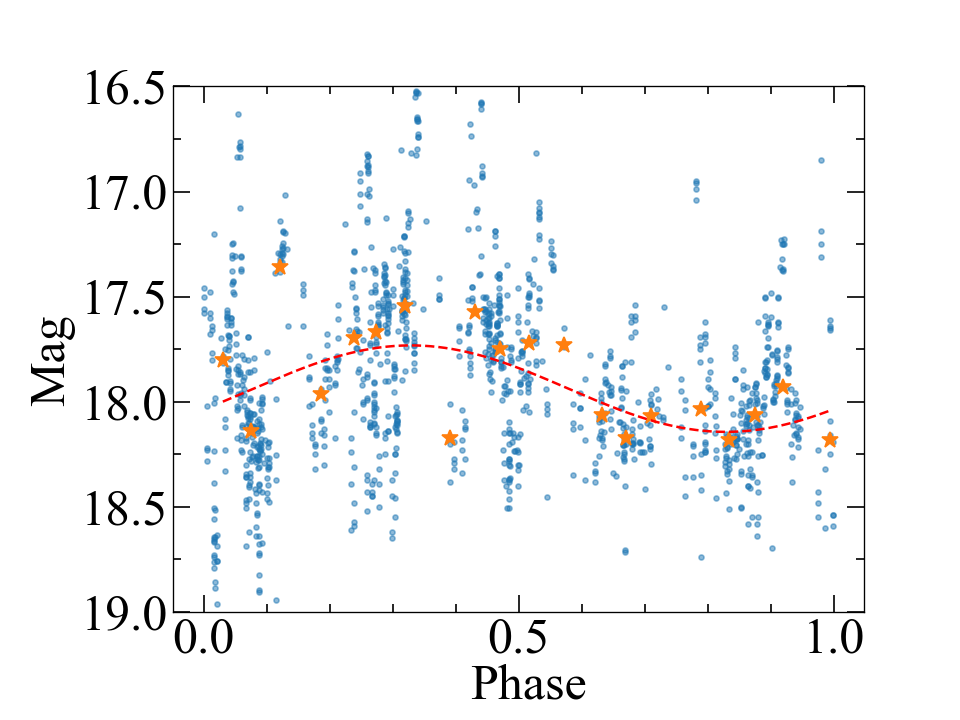

(19.0, 16.5)

In [10]:
#Phase-folded V-band light curve
T_V = 1/best_frequency_V    #The best period obtained from LSP analysis
phase = ((mjd_all - 2000 )%T_V)/T_V    #Folding the time of the light curve according to the best period
rebin_phase_V = wtl.rebin(t=phase, x=mag_all,xe =magerr_all, tduration=0.05)   #Binned the folded light curve





#Sinusoidal fitting of the phase-folded V-band light curve
best_frequency = 1   #The best period is 1
fit_V_fold = sinfit(rebin_phase_V[0],rebin_phase_V[1],rebin_phase_V[2])    #Sinusoidal fitting of the folded V band light curve






# Make phase plot
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
plt.subplots_adjust(left=0.18, bottom=0.15)
plt.gca().tick_params(axis='both',labelsize=30)
plt.xticks(fontsize=30,color='#000000')
plt.yticks(fontsize=30,color='#000000')
plt.plot(phase,mag_all,'.',alpha = 0.5)
plt.plot(rebin_phase_V[0], rebin_phase_V[1],'*',ms = 10)

plt.plot(fit_V_fold[0],fit_V_fold[1],'--', c = 'r')

fig.text(0.55, 0.03, 'Phase', ha='center', fontsize=30)
fig.text(0.03, 0.5, 'Mag', va='center', rotation='vertical', fontsize=30)


plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(top='on', right='on', which='major',length=10, width = 1) 
plt.tick_params(top='on', right='on', which='minor',length=5, width = 1)

plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))

plt.ylim(19,16.5)
#plt.savefig('fig3-1.pdf',dpi=300,bbox_inches='tight')

In [11]:
#Load radio band light curve
radio = pd.read_csv('J2134-0153_radio.csv')

t_radio = np.array(radio['mjd'])
radio_flux = np.array(radio['flux'])
radio_flux_err = np.array(radio['flux_err'])


In [12]:
#LSP analysis of radio band data

best_frequency_radio = LSP(t_radio,radio_flux,radio_flux_err)  #The best frequency obtained from LSP analysis


#Sinusoidal fitting of the radio band light curve
best_frequency = best_frequency_radio
best_fit_radio = sinfit(t_radio,radio_flux,radio_flux_err)



<IPython.core.display.Javascript object>


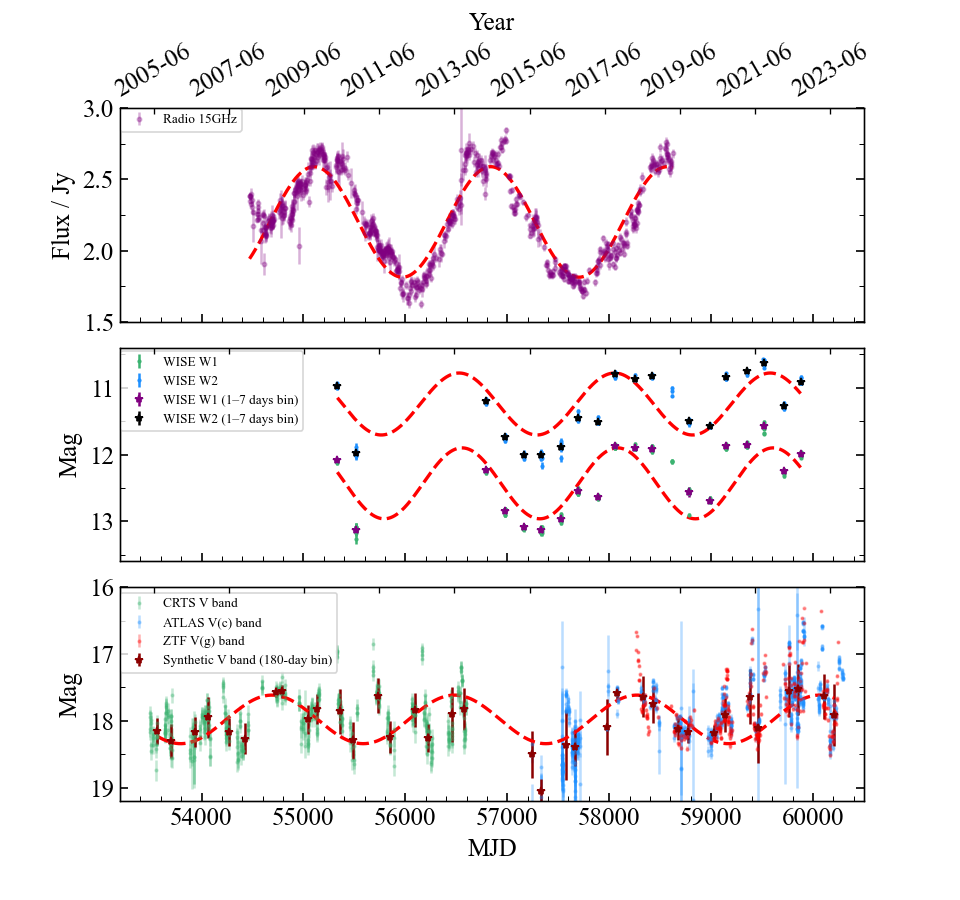

/home/rgw/anaconda3/envs/J2134-0153/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  if __name__ == "__main__":
/home/rgw/anaconda3/envs/J2134-0153/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
/home/rgw/anaconda3/envs/J2134-0153/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
/home/rgw/anaconda3/envs/J2134-0153/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argumen

In [13]:

# Make multi-band light curves plot
fig = plt.figure(figsize=(8,7.5))


#Radio band
ax1 = fig.add_subplot(311)
plt.xlim(53200,60500)
plt.ylim(1.5,3)
ax1.errorbar(t_radio, radio_flux,radio_flux_err, fmt = '.', marker = '.', ms=5, c = 'purple', alpha = 0.3)
ax1.legend(["Radio 15GHz"],loc=(0,0.89),fontsize=8)

ax1.plot(best_fit_radio[0],best_fit_radio[1],'--',c = 'r',lw = 2)
ax1.tick_params(labelbottom=False)

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.ylabel('Flux / Jy',fontsize=15)

plt.gca().xaxis.set_major_locator(MultipleLocator(1000))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().tick_params(axis='both')

ax1.tick_params(top='on', right='on', which='major',length=5, width = 1) 
ax1.tick_params(top='on', right='on', which='minor',length=3)

ax1.tick_params(bottom=True, top=True, left=True, right=True)




Year_X = [53551,54281,55012,55742,56473,57203,57934,58664,59395,60125]
Year_Y = [3,3,3,3,3,3,3,3,3,3]
ax = ax1.twiny()
ax.plot(Year_X,Year_Y,alpha = 0)
ax.set_xticks([53551,54281,55012,55742,56473,57203,57934,58664,59395,60125])
ax.set_xticklabels(['2005-06','2007-06','2009-06','2011-06','2013-06','2015-06','2017-06','2019-06','2021-06','2023-06'], rotation=30, fontsize=15)
ax.set_title('Year', fontsize=15) 




#IR band
ax2 = fig.add_subplot(312)
plt.ylabel('Mag',fontsize=15)
ax2.tick_params(labelbottom=False)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.xlim(53200,60500)
plt.ylim(13.6,10.4)
plt.errorbar(t_WISE_seq, W1_mag_seq, W1_mag_err_seq, fmt = '.', marker = '.', ms=3, c = 'mediumseagreen')
plt.errorbar(t_WISE_seq, W2_mag_seq, W2_mag_err_seq, fmt = '.', marker = '.', ms=3, c = 'dodgerblue', label = 'Radio band')

plt.errorbar(rebin_W1[0], rebin_W1[1],rebin_W1[2], fmt = '*', marker = '*', ms=5, c = 'purple', label = 'Radio band')
plt.errorbar(rebin_W2[0], rebin_W2[1],rebin_W2[2], fmt = '*', marker = '*', ms=5, c = 'black', label = 'Radio band')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
ax2.legend(["WISE W1","WISE W2","WISE W1 (1–7 days bin)","WISE W2 (1–7 days bin)"],loc=(0,0.61),fontsize=8)

plt.gca().xaxis.set_major_locator(MultipleLocator(1000))
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().tick_params(axis='both')
plt.tick_params(top='on', right='on', which='major',length=5, width = 1) 
plt.tick_params(top='on', right='on', which='minor',length=3)

plt.plot(best_fit_W1[0],best_fit_W1[1],'--',c = 'r', lw=2)
plt.plot(best_fit_W2[0],best_fit_W2[1],'--',c = 'r', lw=2)


ax = ax2.twiny()
ax.plot(Year_X,Year_Y,alpha = 0)
ax.set_xticks([53551,54281,55012,55742,56473,57203,57934,58664,59395,60125])
ax.set_xticklabels(['2005-06','2007-06','2009-06','2011-06','2013-06','2015-06','2017-06','2019-06','2021-06','2023-06'], rotation=30, fontsize=15,alpha = 0)


#Optical band
ax3 = fig.add_subplot(313)

plt.ylabel('Mag',fontsize=15)
plt.xlabel('MJD',fontsize=15)
plt.xlim(53200,60500)
plt.ylim(19.2,16)
plt.tick_params(bottom=True, top=True, left=True, right=True)

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.gca().xaxis.set_major_locator(MultipleLocator(1000))
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().tick_params(axis='both')


plt.tick_params(top='on', right='on', which='major',length=5, width = 1) 
plt.tick_params(top='on', right='on', which='minor',length=3)
plt.errorbar(mjd_crts, mag_crts, magerr_crts, fmt = '.', marker = '.', ms=3, c = 'mediumseagreen', label = 'Radio band',alpha = 0.3)
plt.errorbar(mjd_atlas, mag_atlas,magerr_atlas, fmt = '.', marker = '.', ms=3, c = 'dodgerblue', label = 'Radio band',alpha = 0.3)
plt.errorbar(mjd_ztf, mag_ztf, magerr_ztf, fmt = '.', marker = '.', ms=3, c = 'r', label = 'Radio band',alpha = 0.3)

plt.errorbar(rebin_V[0], rebin_V[1], rebin_V[2], fmt = '.', marker = '*', ms=5, c = 'darkred', label = 'V band')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.12)
ax3.legend(["CRTS V band","ATLAS V(c) band","ZTF V(g) band","Synthetic V band (180-day bin)"],loc=(0,0.6),fontsize=8)
plt.plot(best_fit_V[0],best_fit_V[1],'--',c = 'r', lw=2)

ax = ax3.twiny()
ax.plot(Year_X,Year_Y,alpha = 0)
ax.set_xticks([53551,54281,55012,55742,56473,57203,57934,58664,59395,60125])
ax.set_xticklabels(['2005-06','2007-06','2009-06','2011-06','2013-06','2015-06','2017-06','2019-06','2021-06','2023-06'], rotation=30, fontsize=15,alpha = 0)





plt.show()
#plt.savefig('fig1.pdf', dpi = 300)

<IPython.core.display.Javascript object>


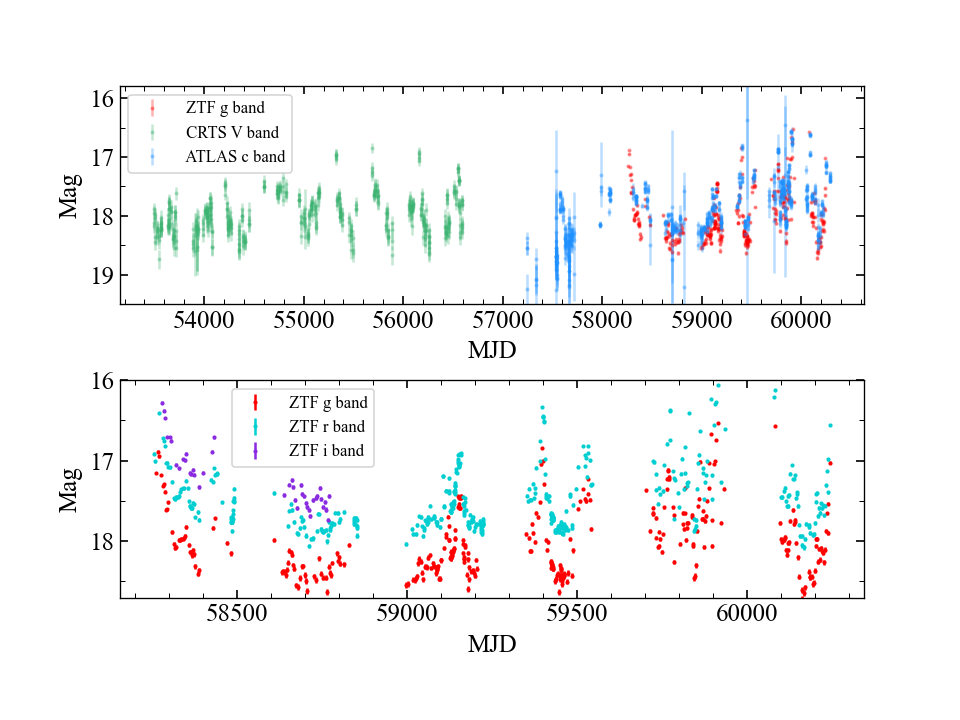

/home/rgw/anaconda3/envs/J2134-0153/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
/home/rgw/anaconda3/envs/J2134-0153/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
/home/rgw/anaconda3/envs/J2134-0153/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
/home/rgw/anaconda3/envs/J2134-0153/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
/hom

In [14]:
#Load ZTF g,r,i band light curves 

sel_ztf_g = np.where((ztf_file['filtercode']=='zg')&(ztf_file['catflags']==0.), True, False)
sel_ztf_r = np.where((ztf_file['filtercode']=='zr')&(ztf_file['catflags']==0.), True, False)
ztf = pf.open('J2134-0153_ztf.fits')
sel_ztf_i = ztf[1].data['filtercode'] == 'zi' 

# g band
t_ztf_g = ztf_file['mjd'][sel_ztf_g]
ztf_mag_g = ztf_file['mag'][sel_ztf_g] 
ztf_mag_g_err = ztf_file['magerr'][sel_ztf_g]

# r band
t_ztf_r = ztf_file['mjd'][sel_ztf_r]
ztf_mag_r = ztf_file['mag'][sel_ztf_r] 
ztf_mag_r_err = ztf_file['magerr'][sel_ztf_r]


# i band
t_ztf_i = ztf[1].data['mjd'][sel_ztf_i]
ztf_mag_i = ztf[1].data['mag'][sel_ztf_i]
ztf_mag_i_err = ztf[1].data['magerr'][sel_ztf_i]

fig = plt.figure(figsize=(8,6))

ax1 = fig.add_subplot(211)



plt.ylabel('Mag',fontsize=15)
plt.xlabel('MJD',fontsize=15)
plt.ylim(18.7,16)
plt.tick_params(bottom=True, top=True, left=True, right=True)



plt.errorbar(ztf_file['mjd'][sel_ztf], ztf_file['mag'][sel_ztf], ztf_file['magerr'][sel_ztf], fmt = '.', marker = '.', ms=3, c = 'red', label = 'Radio band',alpha = 0.3)


plt.errorbar(crts_file['MJD'][sel_crts], crts_file['Mag'][sel_crts], crts_file['Magerr'][sel_crts], fmt = '.', marker = '.', ms=3, c = 'mediumseagreen', label = 'Radio band',alpha = 0.3)

plt.errorbar(atlas_file['MJD'][sel_atlas], atlas_file['m'][sel_atlas] , atlas_file['dm'][sel_atlas], fmt = '.', marker = '.', ms=3, c = 'dodgerblue', label = 'Radio band',alpha = 0.3)


plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.legend([" ZTF g band"," CRTS V band"," ATLAS c band"],loc='best',fontsize=10)
plt.gca().xaxis.set_major_locator(MultipleLocator(1000))
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().tick_params(axis='both')
plt.subplots_adjust(left=None, bottom=0.17, right=None, top=None, wspace=None, hspace=0)
plt.tick_params(top='on', right='on', which='major',length=5, width = 1) 
plt.tick_params(top='on', right='on', which='minor',length=3)
plt.ylim(19.5,15.8)

ax2 = fig.add_subplot(212)
plt.ylabel('Mag',fontsize=15)
plt.xlabel('MJD',fontsize=15)
plt.ylim(18.7,16)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.errorbar(t_ztf_g, ztf_mag_g, ztf_mag_g_err, fmt = '.', marker = '.', ms=3, c = 'r', label = 'Radio band')
plt.errorbar(t_ztf_r, ztf_mag_r, ztf_mag_r_err, fmt = '.', marker = '.', ms=3, c = 'darkturquoise', label = 'Radio band')
plt.errorbar(t_ztf_i, ztf_mag_i, ztf_mag_i_err, fmt = '.', marker = '.', ms=3, c = 'blueviolet', label = 'Radio band')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.legend([" ZTF g band"," ZTF r band"," ZTF i band"],loc=[0.15,0.6],fontsize=10)
plt.gca().xaxis.set_major_locator(MultipleLocator(500))
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().tick_params(axis='both')
plt.subplots_adjust(left=None, bottom=0.17, right=None, top=None, wspace=None, hspace=0)
plt.tick_params(top='on', right='on', which='major',length=5, width = 1) 
plt.tick_params(top='on', right='on', which='minor',length=3)


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)
#plt.savefig('figB1.pdf', dpi = 300)

In [15]:
#Load gamma band light curves

gamma_day = pd.read_csv('4FGL_J2134.2-0154_daily_2023_4_10.csv')
t_gamma_day = gamma_day['Julian Date']-2400000
flux_gamma_day = gamma_day['Photon Flux [0.1-100 GeV](photons cm-2 s-1)']
flux_gammaerr_day = gamma_day['Photon Flux Error(photons cm-2 s-1)']

gamma_week = pd.read_csv('4FGL_J2134.2-0154_weekly_2023_4_10.csv')
t_gamma_week = gamma_week['Julian Date']-2400000
flux_gamma_week = gamma_week['Photon Flux [0.1-100 GeV](photons cm-2 s-1)']
flux_gammaerr_week = gamma_week['Photon Flux Error(photons cm-2 s-1)']

gamma_month = pd.read_csv('4FGL_J2134.2-0154_monthly_2023_4_10.csv')
t_gamma_month = gamma_month['Julian Date']-2400000
flux_gamma_month = gamma_month['Photon Flux [0.1-100 GeV](photons cm-2 s-1)']
flux_gammaerr_month = gamma_month['Photon Flux Error(photons cm-2 s-1)']

<IPython.core.display.Javascript object>


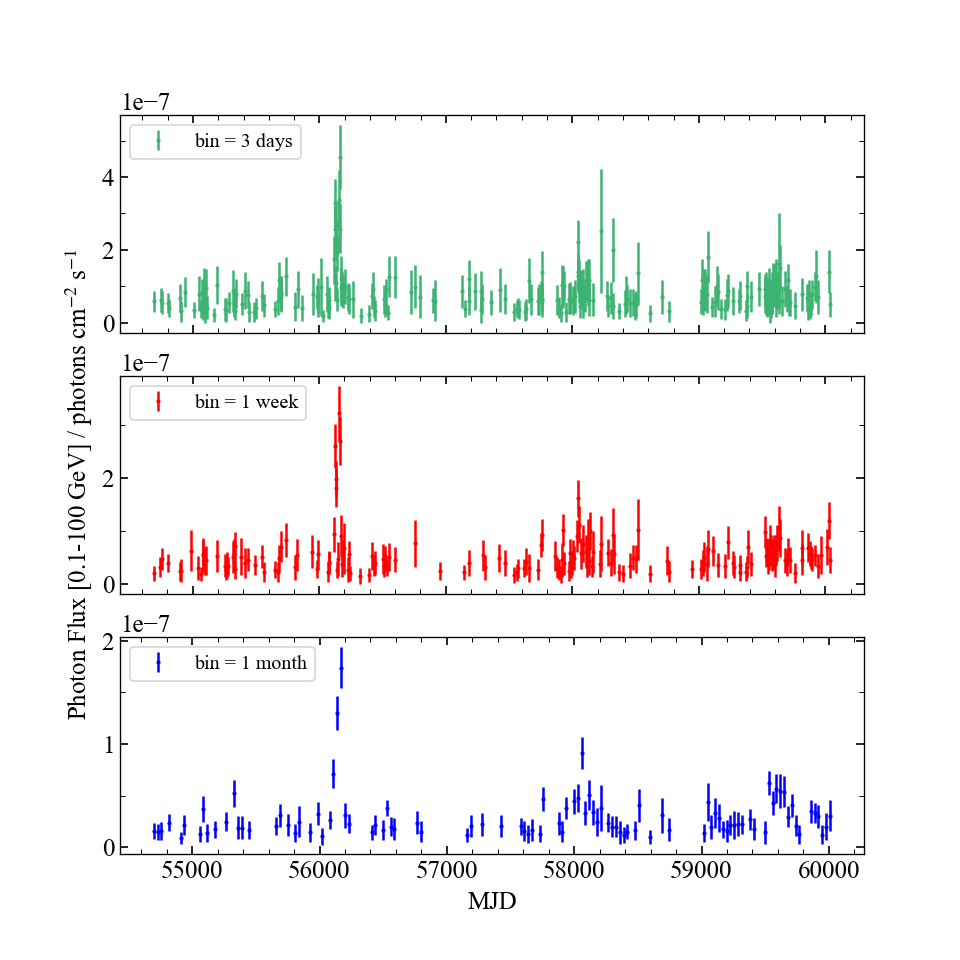

/home/rgw/anaconda3/envs/J2134-0153/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()
/home/rgw/anaconda3/envs/J2134-0153/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
/home/rgw/anaconda3/envs/J2134-0153/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.


In [16]:
#Make ZTF light curves plot
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(311)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.gca().tick_params(axis='both')
ax1.tick_params(labelbottom=False)
plt.tick_params(top='on', right='on', which='major',length=5, width = 1) 
plt.tick_params(top='on', right='on', which='minor',length=3)
plt.errorbar(t_gamma_day, flux_gamma_day, flux_gammaerr_day, fmt = '.', marker = '.', ms=3, c = 'mediumseagreen')
ax1.legend(["bin = 3 days"],loc='upper left',fontsize=12)
plt.gca().xaxis.set_major_locator(MultipleLocator(1000))
plt.gca().yaxis.set_major_locator(MultipleLocator(2e-7))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))

ax2 = fig.add_subplot(312)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.gca().tick_params(axis='both')
ax2.tick_params(labelbottom=False)
plt.tick_params(top='on', right='on', which='major',length=5, width = 1) 
plt.tick_params(top='on', right='on', which='minor',length=3)
plt.errorbar(t_gamma_week, flux_gamma_week, flux_gammaerr_week, fmt = '.', marker = '.', ms=3, c = 'r')
ax2.legend(["bin = 1 week"],loc='upper left',fontsize=12)
plt.gca().xaxis.set_major_locator(MultipleLocator(1000))
plt.gca().yaxis.set_major_locator(MultipleLocator(2e-7))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.ylabel('Photon Flux [0.1-100 GeV] / photons cm$^{-2}$ s$^{-1}$')

ax3 = fig.add_subplot(313)
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.gca().tick_params(axis='both')


plt.tick_params(top='on', right='on', which='major',length=5, width = 1) 
plt.tick_params(top='on', right='on', which='minor',length=3)
plt.errorbar(t_gamma_month, flux_gamma_month, flux_gammaerr_month, fmt = '.', marker = '.', ms=3, c = 'b')
ax3.legend(["bin = 1 month"],loc='upper left',fontsize=12)
plt.gca().xaxis.set_major_locator(MultipleLocator(1000))
plt.gca().yaxis.set_major_locator(MultipleLocator(1e-7))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.xlabel('MJD')
plt.show()
#plt.savefig('figA1.pdf', dpi = 300)